<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})

In [2]:
url = "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/"
r = requests.get(url)
soup = BeautifulSoup.BeautifulSoup(r.text)
ressources_list = soup.find("div", "resources-list")
url = None
for article in ressources_list.find_all("article"):
  if 'donnees-hospitalieres-nouveaux-covid19' in article.div.h4.text:
    url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
    break
if url == None:
  raise("data not found")
df = pd.read_csv(url, sep=";")
df.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
5247,976,2020-05-05,7,2,2,3
5248,976,2020-05-06,8,1,1,6
5249,976,2020-05-07,11,1,0,4
5250,976,2020-05-08,6,2,0,3
5251,976,2020-05-09,6,0,0,5


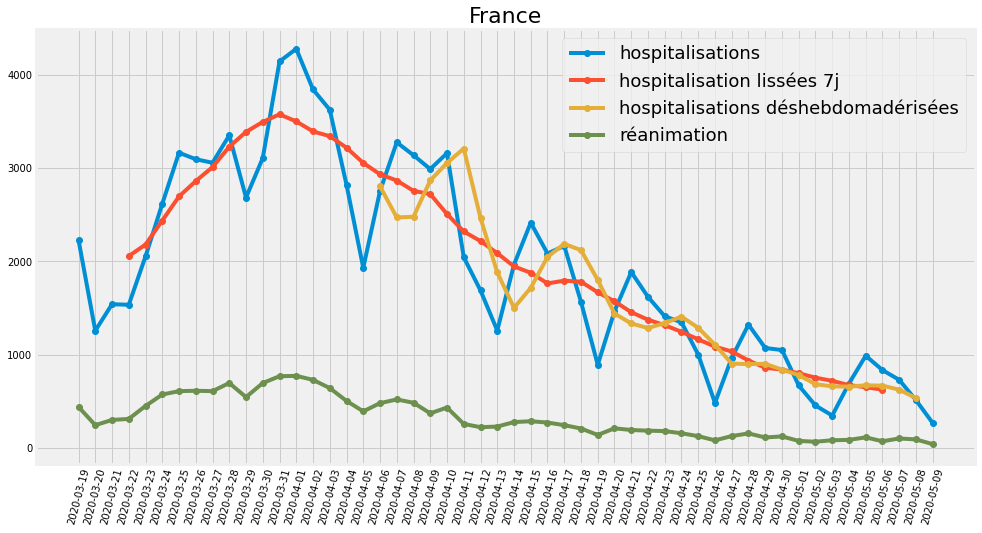

,incid_hosp,incid_rea
jour,,
2020-05-05,751.428571,91.857143
2020-05-06,717.571429,86.000000
2020-05-07,671.857143,82.857143
2020-05-08,649.285714,85.142857
2020-05-09,622.428571,81.428571


In [3]:
daily = df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum()

lissage_hebdo = daily.rolling(7, center=True).mean()
lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

# essai de "désaisonnaliser" sur le rythme hebdo des trois dernières semaines + lissage 3j

# moyennes par jour sur les 3 dernières semaines
modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()


# soustraire le trend (linéarisation sur 3 semaines)
modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
# matrice de correction
modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)

desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
france = pd.concat([daily, lissage_hebdo, desaiso], axis=1)

plt.figure(figsize=(15,8))
plt.plot(france[["incid_hosp",  "hosp_lisse", "hosp_desaiso","incid_rea"]], marker="o")
plt.xticks(rotation=75)
plt.title("France", fontsize=22)
plt.legend(["hospitalisations",
            "hospitalisation lissées 7j",
            "hospitalisations déshebdomadérisées",
            "réanimation"], loc=1, fontsize=18)
plt.show()
daily.rolling(7).mean().tail()

In [0]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())

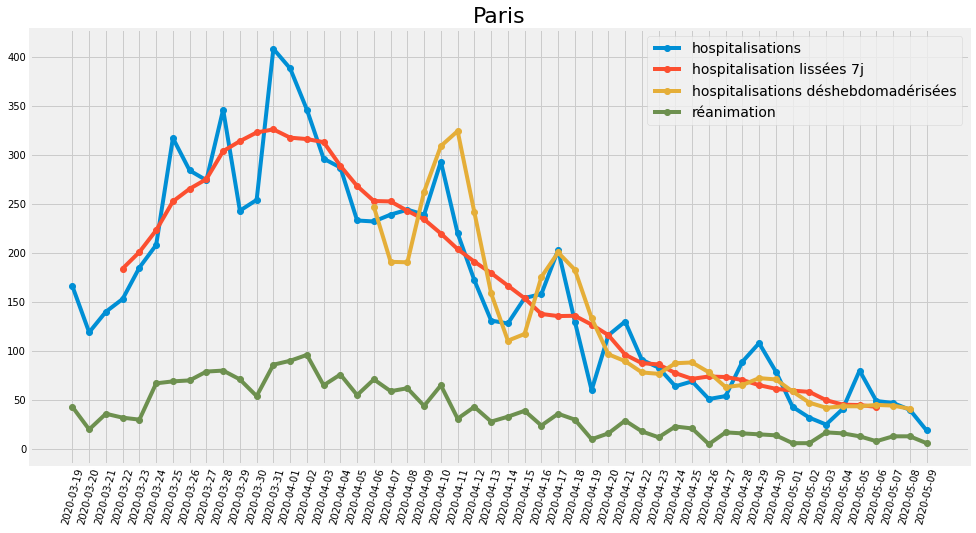


dernières données lissées 7j: 

            incid_hosp  incid_rea  ...  hosp_desaiso  rea_desaiso
2020-05-05        58.0       12.0  ...          54.0         13.0
2020-05-06        50.0       11.0  ...          50.0         12.0
2020-05-07        45.0       11.0  ...          46.0         12.0
2020-05-08        45.0       12.0  ...          44.0         12.0
2020-05-09        43.0       12.0  ...           NaN          NaN

[5 rows x 6 columns]


In [5]:
display_dept("75", "Paris")

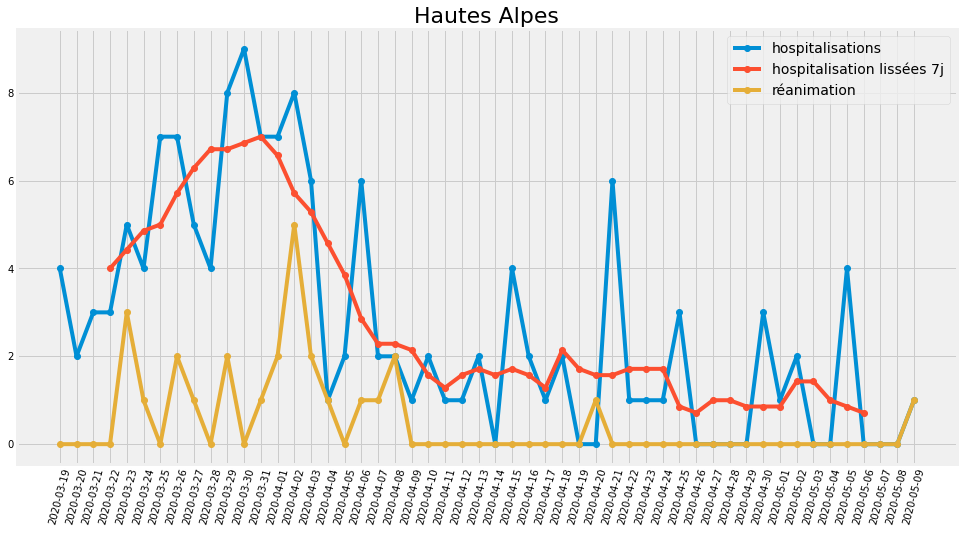


dernières données lissées 7j: 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-05-05         1.0        0.0         1.0        0.0
2020-05-06         1.0        0.0         1.0        0.0
2020-05-07         1.0        0.0         NaN        NaN
2020-05-08         1.0        0.0         NaN        NaN
2020-05-09         1.0        0.0         NaN        NaN


In [6]:
display_dept("05","Hautes Alpes")

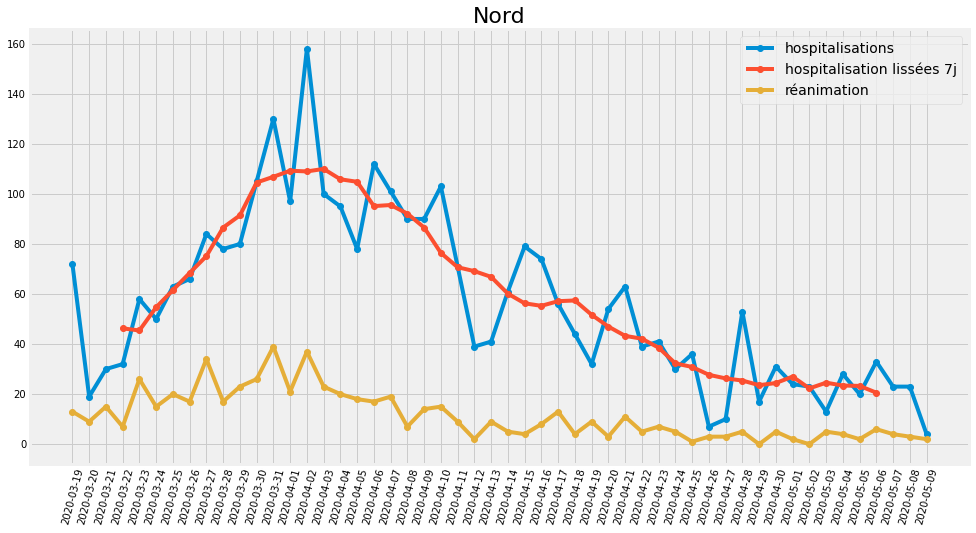


dernières données lissées 7j: 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-05-05        22.0        3.0        24.0        3.0
2020-05-06        25.0        3.0        24.0        3.0
2020-05-07        23.0        3.0         NaN        NaN
2020-05-08        23.0        3.0         NaN        NaN
2020-05-09        21.0        4.0         NaN        NaN


In [7]:
display_dept("59","Nord")

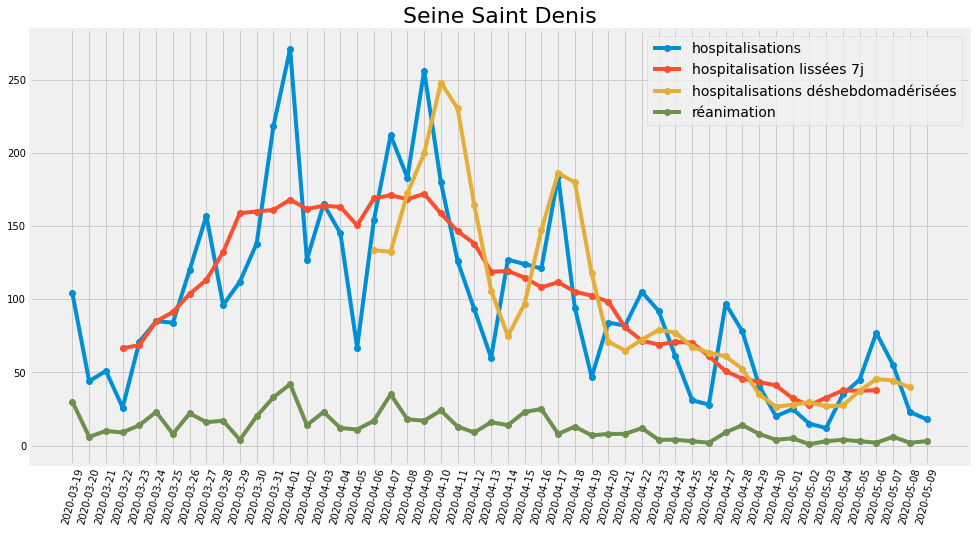


dernières données lissées 7j: 

            incid_hosp  incid_rea  ...  hosp_desaiso  rea_desaiso
2020-05-05        28.0        4.0  ...          30.0          4.0
2020-05-06        33.0        3.0  ...          32.0          4.0
2020-05-07        38.0        3.0  ...          34.0          4.0
2020-05-08        37.0        3.0  ...          36.0          4.0
2020-05-09        38.0        3.0  ...           NaN          NaN

[5 rows x 6 columns]


In [8]:
display_dept("93","Seine Saint Denis")

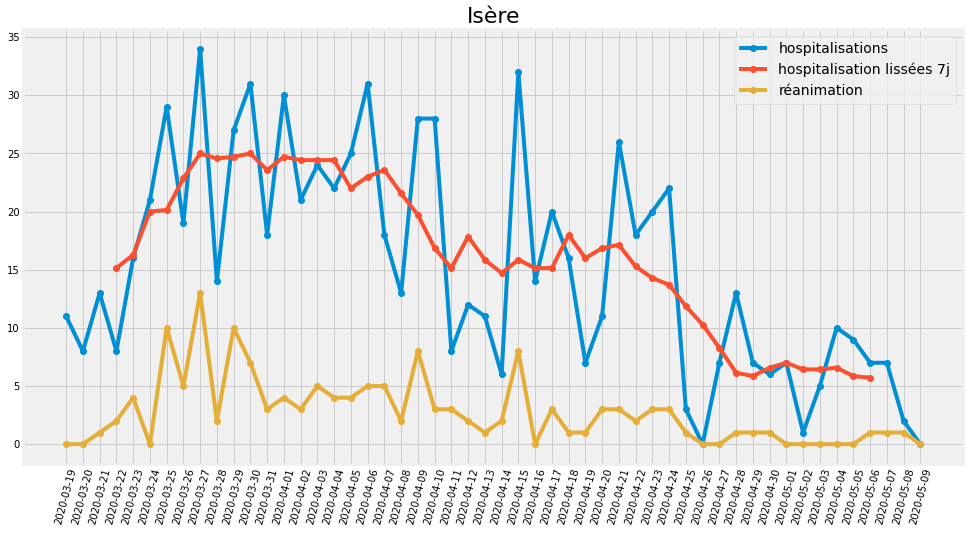


dernières données lissées 7j: 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-05-05         6.0        0.0         6.0        0.0
2020-05-06         6.0        0.0         6.0        0.0
2020-05-07         7.0        0.0         NaN        NaN
2020-05-08         6.0        0.0         NaN        NaN
2020-05-09         6.0        0.0         NaN        NaN


In [9]:
display_dept("38","Isère")